# MGL870 - TP2 - Utilisation de l’apprentissage machine pour la détection des anomalies
## Pierre Joseph, Jonathan Mésidor, Mohamed Fehd Soufi
## Automne 2024


## Import required libraries

In [ ]:
import os
import pandas as pd
import sys
sys.path.append('../../')
from logparser.Drain import LogParser
import re
import json
from collections import defaultdict
from tqdm import tqdm

## Preparation of the log files

### Split log file into train-valid-test (60-20-20)

In [ ]:
import os

def split_logfile(input_file, train_file, valid_file, test_file, train_ratio=0.6, valid_ratio=0.2):
    """
    Splits a file into train, validation, and test sets based on the given ratios.

    Parameters:
    input_file (str): Path to the input file.
    train_file (str): Path to the output train file.
    valid_file (str): Path to the output validation file.
    test_file (str): Path to the output test file.
    train_ratio (float): Ratio of the train set size to the total size (default is 0.6).
    valid_ratio (float): Ratio of the validation set size to the total size (default is 0.2).
    """
    # Read the input file
    with open(input_file, 'r') as file:
        lines = file.readlines()

    # Calculate split indices
    train_split_index = int(len(lines) * train_ratio)
    valid_split_index = int(len(lines) * (train_ratio + valid_ratio))

    # Split the lines into train, validation, and test sets
    train_lines = lines[:train_split_index]
    valid_lines = lines[train_split_index:valid_split_index]
    test_lines = lines[valid_split_index:]

    # Write the train set to the train file
    with open(train_file, 'w') as file:
        file.writelines(train_lines)

    # Write the validation set to the validation file
    with open(valid_file, 'w') as file:
        file.writelines(valid_lines)

    # Write the test set to the test file
    with open(test_file, 'w') as file:
        file.writelines(test_lines)

    print(f"Split completed: \n {len(train_lines)} lines in {train_file} \n {len(valid_lines)} lines in {valid_file} \n {len(test_lines)} lines in {test_file}")


In [ ]:
split_logfile(input_file='input/HDFS_v1/HDFS.log', 
              train_file='input/HDFS_v1/HDFS_train.log', 
              valid_file='input/HDFS_v1/HDFS_valid.log', 
              test_file='input/HDFS_v1/HDFS_test.log')

#Split completed: 
# 6705377 lines in input/HDFS_v1/HDFS_train.log 
# 2235126 lines in input/HDFS_v1/HDFS_valid.log 
# 2235126 lines in input/HDFS_v1/HDFS_test.log

### Drain 3 parser on HDFS_train.log, HDFS_valid.log and HDFS_test.log

In [ ]:
input_dir  = 'input/HDFS_v1/'  # The input directory of log files
output_dir = 'HDFS_results/'  # The output directory of parsing results
log_files  = ['HDFS_train.log', 'HDFS_valid.log', 'HDFS_test.log']  # List of input log file names
log_format = '<Date> <Time> <Pid> <Level> <Component>: <Content>'  # HDFS log format

# Regular expression list for optional preprocessing (default: [])
regex = [
    r'blk_(|-)[0-9]+',  # block id
    r'(/|)([0-9]+\.){3}[0-9]+(:[0-9]+|)(:|)',  # IP
    r'(?<=[^A-Za-z0-9])(\-?\+?\d+)(?=[^A-Za-z0-9])|[0-9]+$',  # Numbers
]
st = 0.5  # Similarity threshold
depth = 4  # Depth of all leaf nodes

parser = LogParser(log_format, indir=input_dir, outdir=output_dir, depth=depth, st=st, rex=regex)

# Iterate over each log file and parse it
for log_file in log_files:
    parser.parse(log_file)

### Mapping
We created the EventId mapping to have a clearer matrix of events. First we sort the EventId by order of magnitude then we associate a value E(x) = {E0, E1, E2 .... } to each one

In [ ]:
def mapping(file_names, output_dir):
    """
    Process multiple log template CSV files and save the mappings to JSON files in a specified output directory.
    
    Parameters:
        file_names (list): A list of CSV file names to process.
        output_dir (str): The directory where output JSON files will be saved.
    """
    # Assure that the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    for file_name in file_names:
        log_templates_file = os.path.join(output_dir, file_name)
        
        # Lire le fichier CSV et créer le dictionnaire de mappage
        log_temp = pd.read_csv(log_templates_file).sort_values(by="Occurrences", ascending=False)
        log_temp_dict = {event: f"E{idx + 1}" for idx, event in enumerate(log_temp["EventId"])}
        
        # Définir le nom du fichier de sortie
        output_file = os.path.join(output_dir, f"{file_name.replace('.csv', '')}.json")
        
        # Sauvegarder le dictionnaire de mappage
        with open(output_file, "w") as f:
            json.dump(log_temp_dict, f)
        
        print(f"Mapping completed and saved to {output_file}")

In [ ]:
files = [
    "HDFS_train.log_templates.csv",
    "HDFS_valid.log_templates.csv",
    "HDFS_test.log_templates.csv"
]
output_directory = "./HDFS_results/"

mapping(files, output_directory)

### Convert the structure of HDFS to have Blk
Adding the columns BlockId, Label and Change the EventId to E1, E2, E3 ... so that we can have a complete structure.

In [ ]:
def process_log_files(input_dir, output_dir, json_filename, structured_log_filename, anomaly_label_filename, output_filename):
    """
    Process log files to add BlockId, map EventId values, and label anomalies.
    
    Parameters:
        input_dir (str): The directory containing the input files.
        output_dir (str): The directory for output files.
        json_filename (str): The JSON file with EventId mappings.
        structured_log_filename (str): The CSV file with structured log data.
        anomaly_label_filename (str): The CSV file with anomaly labels.
        output_filename (str): The filename for the processed output.
    """
    # Paths for the input files
    json_file_path = os.path.join(output_dir, json_filename)
    anomaly_label_path = os.path.join(input_dir, anomaly_label_filename)
    structured_log_path = os.path.join(output_dir, structured_log_filename)
    
    # Load the structured log file
    df_structured = pd.read_csv(structured_log_path)

    # Load the JSON mapping file
    with open(json_file_path, 'r') as json_file:
        event_mapping = json.load(json_file)

    # Load the anomaly label file
    df_labels = pd.read_csv(anomaly_label_path)
    df_labels['Label'] = df_labels['Label'].replace({'Normal': 'Success', 'Anomaly': 'Fail'})

    # Add BlockId by extracting block identifiers
    df_structured['BlockId'] = df_structured['Content'].apply(lambda x: re.search(r'blk_(|-)[0-9]+', x).group(0) if re.search(r'blk_(|-)[0-9]+', x) else None)

    # Remove rows where BlockId is NaN
    df_structured = df_structured.dropna(subset=['BlockId'])

    # Map EventId using the JSON file
    df_structured['EventId'] = df_structured['EventId'].apply(lambda x: event_mapping.get(x, x))

    # Merge DataFrames to add the Label column
    df_structured = pd.merge(df_structured, df_labels, on='BlockId', how='left')

    # Reorder columns so BlockId and Label are first
    columns = ['BlockId', 'Label'] + [col for col in df_structured.columns if col not in ['BlockId', 'Label']]
    df_structured = df_structured[columns]

    # Save the processed structured log file
    output_path = os.path.join(output_filename)
    df_structured.to_csv(output_path, index=False)

    print(f"Le fichier structuré avec BlockId et les EventId remplacés est généré et sauvegardé dans {output_path}")



In [ ]:
# Train
process_log_files(
    input_dir='./input/HDFS_v1/',
    output_dir='./HDFS_results',
    json_filename='HDFS_train.log_templates.json',
    structured_log_filename='HDFS_train.log_structured.csv',
    anomaly_label_filename='preprocessed/anomaly_label.csv',
    output_filename='HDFS_train.log_structured_blk.csv'
)

In [ ]:
# Valid
process_log_files(
    input_dir='./input/HDFS_v1/',
    output_dir='./HDFS_results',
    json_filename='HDFS_valid.log_templates.json',
    structured_log_filename='HDFS_valid.log_structured.csv',
    anomaly_label_filename='preprocessed/anomaly_label.csv',
    output_filename='HDFS_valid.log_structured_blk.csv'
)

In [ ]:
# Test
process_log_files(
    input_dir='./input/HDFS_v1/',
    output_dir='./HDFS_results',
    json_filename='HDFS_test.log_templates.json',
    structured_log_filename='HDFS_test.log_structured.csv',
    anomaly_label_filename='preprocessed/anomaly_label.csv',
    output_filename='HDFS_test.log_structured_blk.csv'
)

### Sample

In [ ]:
def hdfs_sampling(file_names, input_dir, output_dir, window='session', window_size=0):
    """
    Perform HDFS sampling on multiple structured log files.

    Parameters:
        file_names (list): A list of file names to process.
        input_dir (str): The directory containing the input structured log files.
        output_dir (str): The directory where output files will be saved.
        window (str): The type of windowing (default is 'session').
        window_size (int): The size of the window (not used for session windowing).
    """
    assert window == 'session', "Only window=session is supported for HDFS dataset."
    os.makedirs(output_dir, exist_ok=True)

    for file_name in file_names:
        input_path = os.path.join(input_dir, file_name)
        output_path = os.path.join(output_dir, file_name.replace('.csv', '_sequence.csv'))

        print("Loading", input_path)

        # Load the structured log file with optimized data types for large files
        struct_log = pd.read_csv(input_path, engine='c', na_filter=False, memory_map=True, dtype={'Time': str})
        
        # Standardize the Time format by adding leading zeros for HHMMSS format
        struct_log['Time'] = struct_log['Time'].str.zfill(6)

        # Pad Date values with zeros to ensure uniform length of 6
        struct_log['Date'] = struct_log['Date'].astype(str).str.zfill(6)
        
        # Extract BlockId, fill EventId missing values, and map Label to binary
        struct_log['BlockId'] = struct_log['Content'].str.extract(r'(blk_-?\d+)')
        struct_log['EventId'] = struct_log['EventId'].fillna('')
        struct_log['Label'] = struct_log['Label'].apply(lambda x: 1 if x == 'Fail' else 0)

        # Initialize dictionaries to store results
        data_dict = defaultdict(list)
        time_dict = defaultdict(list)
        date_dict = defaultdict(list)
        type_count = defaultdict(int)

        # Group by BlockId for bulk operations
        grouped = struct_log.groupby('BlockId')
        for block_id, group in tqdm(grouped, total=len(grouped)):
            data_dict[block_id] = group['EventId'].tolist()
            time_dict[block_id] = pd.to_datetime(group['Time'], format='%H%M%S', errors='coerce').dropna()
            date_dict[block_id] = group['Date'].tolist()
            type_count[block_id] = group['Label'].sum()  # Count occurrences of "Fail"

        # Build the final DataFrame
        rows = []
        for block_id, events in tqdm(data_dict.items(), total=len(data_dict)):
            features = [event for event in events if event]

            times = time_dict[block_id]
            dates = date_dict[block_id]
            if len(times) > 1:
                time_intervals = [(times.iloc[i] - times.iloc[i - 1]).total_seconds() for i in range(1, len(times))]
                latency = (times.iloc[-1] - times.iloc[0]).total_seconds()
            else:
                time_intervals = []
                latency = 0

            label = 'Fail' if type_count[block_id] > 0 else 'Success'

            # Use the first occurrence of Date and Time as representative for each BlockId
            first_date = dates[0] if dates else ''
            first_time = times.iloc[0].strftime('%H%M%S') if not times.empty else ''

            rows.append({
                "BlockId": block_id,
                "Label": label,
                "Type": type_count[block_id],
                "Features": str(features),
                "Date": first_date,
                "Time": first_time,
                "TimeInterval": str(time_intervals),
                "Latency": latency
            })

        data_df = pd.DataFrame(rows, columns=['BlockId', 'Label', 'Type', 'Features', 'Date', 'Time', 'TimeInterval', 'Latency'])
        data_df.to_csv(output_path, index=False)
        print(f"HDFS sampling completed. Output saved to {output_path}")

In [ ]:
files = [
    'HDFS_train.log_structured_blk.csv',
    'HDFS_valid.log_structured_blk.csv',
    'HDFS_test.log_structured_blk.csv'
]
hdfs_sampling(files, input_dir='HDFS_results/', output_dir='HDFS_results/')

### Event Occurence Matrix

In [ ]:
def generate_event_occurrence_matrix(log_files, event_traces_files, input_dir, output_dir, event_columns=None):
    """
    Generate event occurrence matrices for multiple log files.

    Parameters:
        log_files (list): A list of log file names (e.g., ['HDFS_train.log', 'HDFS_valid.log']).
        event_traces_files (list): A list of corresponding event trace CSV files (e.g., ['output/HDFS_train.log_structured_blk_sequence.csv']).
        input_dir (str): The directory where the log files and other inputs are located.
        output_dir (str): The directory where the output CSV files should be saved.
        event_columns (list): List of event columns (e.g., ['E1', 'E2', ..., 'E29']). If None, defaults to ['E1' to 'E29'].
    """
    if event_columns is None:
        event_columns = [f"E{i}" for i in range(1, 30)]  # Default event columns (E1 to E29)

    # Path to the anomaly label file
    anomaly_label_file = os.path.join(input_dir, "preprocessed/anomaly_label.csv")

    # Load anomaly labels and map them (only once)
    anomaly_labels = pd.read_csv(anomaly_label_file)
    anomaly_labels['Label'] = anomaly_labels['Label'].apply(lambda x: 'Fail' if x == 'Anomaly' else 'Success')
    label_dict = anomaly_labels.set_index('BlockId')['Label'].to_dict()

    # Iterate over each log file and corresponding event trace file
    for log_file, event_traces_file in zip(log_files, event_traces_files):
        output_file = os.path.join(output_dir, f"Event_occurence_matrix_{log_file.replace('.log', '')}.csv")
        print(f"Processing {log_file}...")

        # Load the corresponding event traces for the current log file
        event_traces = pd.read_csv(event_traces_file)

        # Initialize occurrence matrix for each log file
        occurrence_matrix = []

        # Iterate over each row to build the occurrence matrix
        for _, row in event_traces.iterrows():
            block_id = row['BlockId']
            label = label_dict.get(block_id, 'Unknown')
            features = row['Features']
            event_list = re.findall(r"E\d+", features)

            # Count occurrences of each event
            event_counts = {event: event_list.count(event) for event in event_columns}
            
            # Add each entry to the occurrence matrix with Time and Date
            occurrence_matrix.append({
                "BlockId": block_id,
                "Label": label,
                "Type": int(row['Type']) if pd.notna(row['Type']) else 0,  # Ensure integer for Type
                "Time": row['Time'] if 'Time' in row else '',
                "Date": row['Date'] if 'Date' in row else '',
                **event_counts
            })

        # Convert to DataFrame and save
        occurrence_matrix_df = pd.DataFrame(occurrence_matrix)
        occurrence_matrix_df = occurrence_matrix_df[['BlockId', 'Label', 'Type', 'Time', 'Date'] + event_columns]
        occurrence_matrix_df.to_csv(output_file, index=False)
        print(f"Event occurrence matrix for {log_file} saved to {output_file}")



In [ ]:
log_files = ['HDFS_train.log', 'HDFS_valid.log', 'HDFS_test.log']
event_traces_files = [
    'HDFS_results/HDFS_train.log_structured_blk_sequence.csv',
    'HDFS_results/HDFS_valid.log_structured_blk_sequence.csv',
    'HDFS_results/HDFS_test.log_structured_blk_sequence.csv'
]
input_dir = './input/HDFS_v1/'
output_dir = './HDFS_results/'

generate_event_occurrence_matrix(log_files, event_traces_files, input_dir, output_dir)

### Statistiques

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def generate_HDFS_statistiques(matrix_path):
    # Load the HDFS_v1 event occurrence matrix    
    df = pd.read_csv(matrix_path)

    # Replace "Fail" and "Success" with numeric labels for easier analysis
    df['Label'] = df['Label'].apply(lambda x: 1 if x == 'Fail' else 0)

    # --- Basic Statistics ---
    total_blocks = len(df)
    total_failures = df['Label'].sum()
    failure_percentage = (total_failures / total_blocks) * 100

    print(f"Total Blocks: {total_blocks}")
    print(f"Total Failures: {total_failures}")
    print(f"Failure Percentage: {failure_percentage:.2f}%")

    # --- Failures by Event Type ---
    event_columns = [col for col in df.columns if col.startswith("E")]
    failure_event_counts = df[df['Label'] == 1][event_columns].sum()

    print("\nTop Events Contributing to Failures:")
    print(failure_event_counts.sort_values(ascending=False).head(10))

    # Plot: Top 10 Events Contributing to Failures
    plt.figure(figsize=(10, 6))
    failure_event_counts.sort_values(ascending=False).head(10).plot(kind='bar', color='red', alpha=0.7)
    plt.title("Top 10 Events Contributing to Failures")
    plt.xlabel("Event")
    plt.ylabel("Failure Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # --- Distribution of Failures Across Time ---
    if 'Time' in df.columns and 'Date' in df.columns:
        # Ensure Date and Time columns are strings
        df['Date'] = df['Date'].astype(str).str.zfill(6)  # Pad with zeros to ensure 6 characters
        df['Time'] = df['Time'].astype(str).str.zfill(6)  # Pad with zeros to ensure 6 characters

        # Convert MMDDYY to a standard YYYYMMDD format
        
        df['FormattedDate'] = df['Date'].apply(lambda x: f"20{x[:2]}{x[2:4]}{x[4:]}")  # Convert YYMMDD to YYYYMMDD
        # Combine FormattedDate and Time
        df['Datetime'] = pd.to_datetime(df['FormattedDate'] + df['Time'], format='%Y%m%d%H%M%S', errors='coerce')      

        failures_over_time = df[df['Label'] == 1].groupby('Datetime').size()

        print("\nFailures Over Time:")
        print(failures_over_time)

        # Plot: Failures Over Time
        plt.figure(figsize=(12, 6))
        failures_over_time.plot(kind='line', marker='o', color='blue')
        plt.title("Failures Over Time")
        plt.xlabel("Datetime")
        plt.ylabel("Number of Failures")
        plt.grid()
        plt.tight_layout()
        plt.show()

    # --- Event Co-occurrence in Failures ---
    failure_events_matrix = df[df['Label'] == 1][event_columns]
    event_cooccurrence = failure_events_matrix.T.dot(failure_events_matrix)
    sns.heatmap(event_cooccurrence, cmap="Reds", annot=False, cbar=True, square=True, xticklabels=5, yticklabels=5)
    plt.title("Event Co-occurrence in Failures")
    plt.xlabel("Event")
    plt.ylabel("Event")
    plt.tight_layout()
    plt.show()

    # --- Distribution of Failures by Type ---
    if 'Type' in df.columns:
        failure_types = df[df['Label'] == 1]['Type'].value_counts()

        print("\nFailures by Type:")
        print(failure_types)

        # Plot: Distribution of Failures by Type
        plt.figure(figsize=(10, 6))
        failure_types.plot(kind='bar', color='orange', alpha=0.8)
        plt.title("Distribution of Failures by Type")
        plt.xlabel("Type")
        plt.ylabel("Failure Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


Total Blocks: 333405
Total Failures: 10996
Failure Percentage: 3.30%

Top Events Contributing to Failures:
E1     29729
E2     26361
E3     20705
E5     20609
E4     20606
E6     18122
E7     11436
E9     10996
E8      8259
E10     2960
dtype: int64


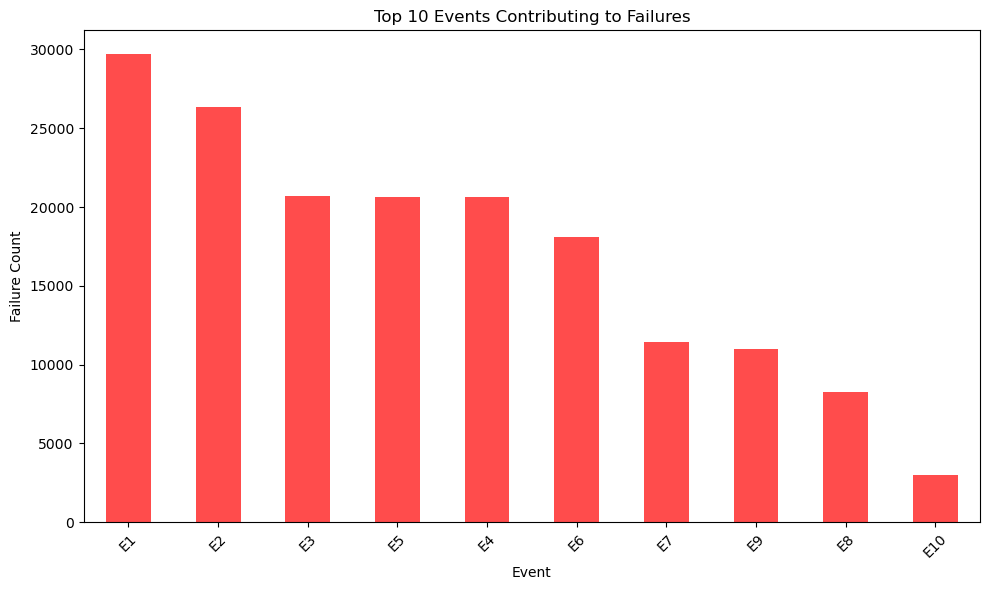


Failures Over Time:
Datetime
2008-11-09 20:35:21    1
2008-11-09 20:35:30    1
2008-11-09 20:35:31    1
2008-11-09 20:35:32    1
2008-11-09 20:35:33    1
                      ..
2008-11-11 03:57:13    1
2008-11-11 03:57:15    2
2008-11-11 03:57:16    1
2008-11-11 03:57:28    1
2008-11-11 03:57:31    1
Length: 9083, dtype: int64


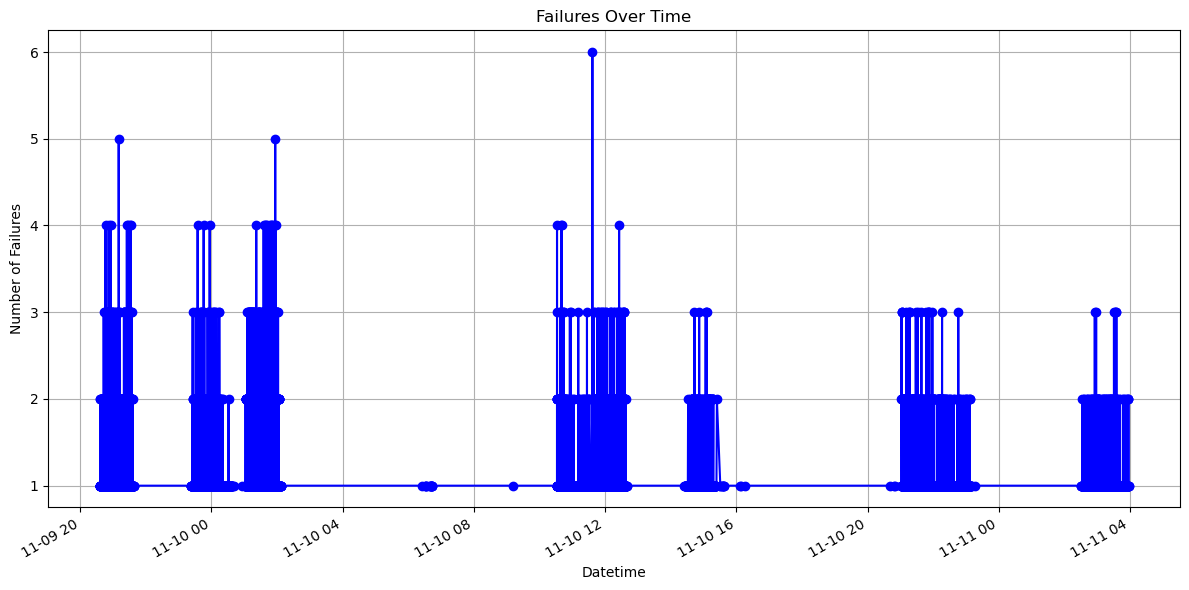

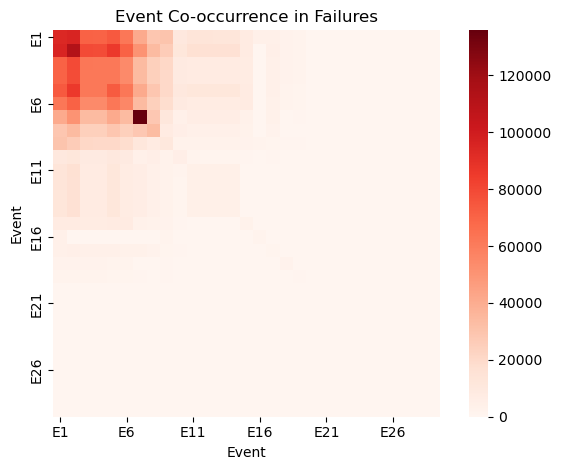


Failures by Type:
Type
4      2093
2      1999
20     1616
13      468
21      454
41      358
27      338
26      333
24      331
30      305
29      303
23      280
25      247
33      222
22      202
32      189
28      174
42      173
31      162
38      151
14      145
19       85
39       84
16       49
40       41
43       38
34       37
37       31
36       21
44       11
35       10
8        10
15        9
3         6
45        5
46        4
48        2
12        2
230       1
52        1
56        1
223       1
17        1
61        1
50        1
51        1
Name: count, dtype: int64


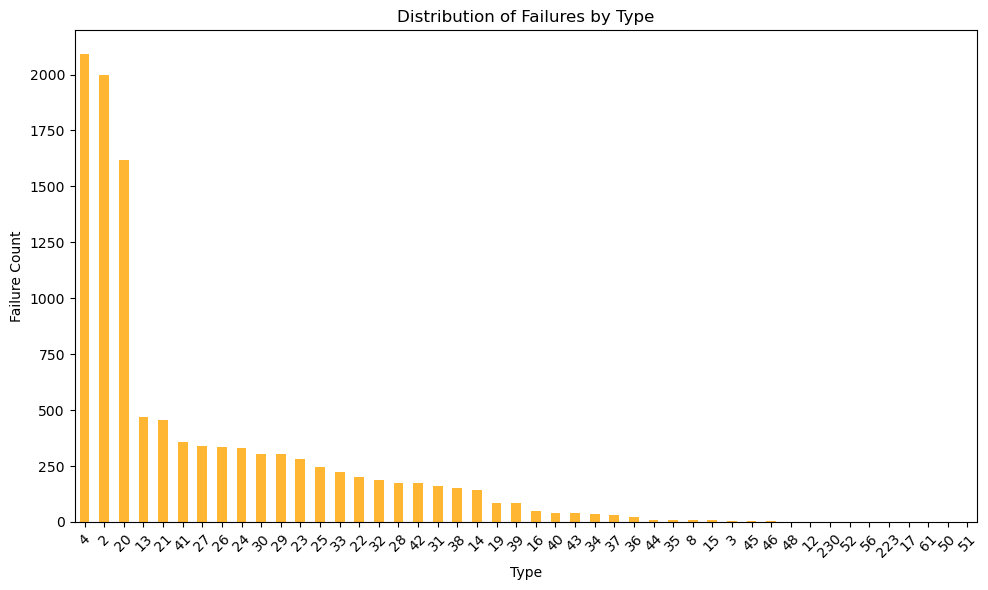

In [6]:
# Train
matrix_path  = "HDFS_results/Event_occurence_matrix_HDFS_train.csv"
generate_HDFS_statistiques(matrix_path)

Total Blocks: 191205
Total Failures: 4741
Failure Percentage: 2.48%

Top Events Contributing to Failures:
E2     11314
E1     10186
E3      8583
E4      8479
E5      4495
E7      3858
E6      3569
E9      1160
E11     1147
E12     1147
dtype: int64


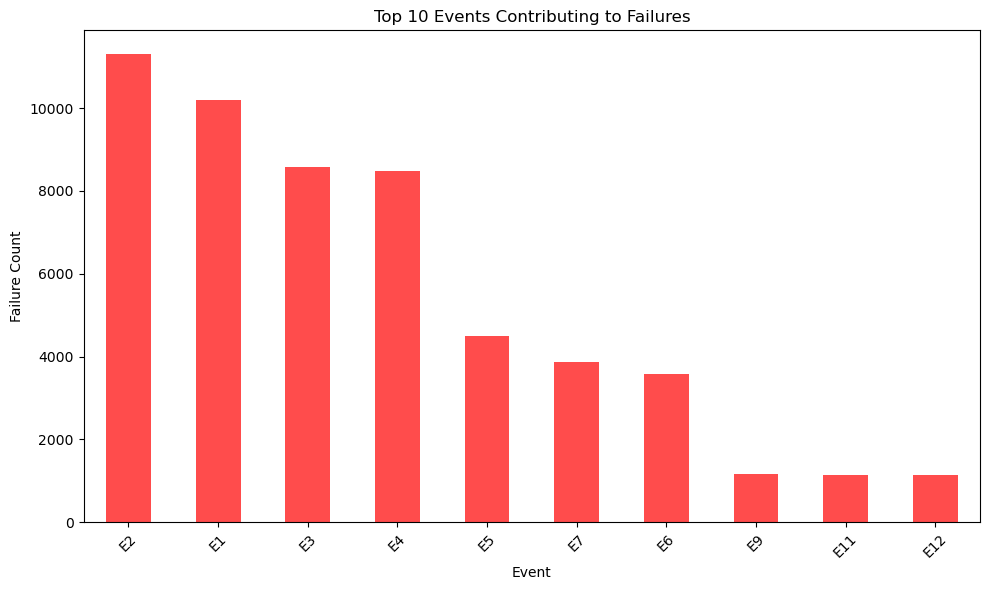


Failures Over Time:
Datetime
2008-11-11 03:57:40    1
2008-11-11 03:57:47    1
2008-11-11 03:57:48    1
2008-11-11 03:57:52    2
2008-11-11 03:57:53    1
                      ..
2008-11-11 07:33:15    1
2008-11-11 07:33:16    1
2008-11-11 07:33:21    1
2008-11-11 07:33:29    1
2008-11-11 07:33:31    1
Length: 3200, dtype: int64


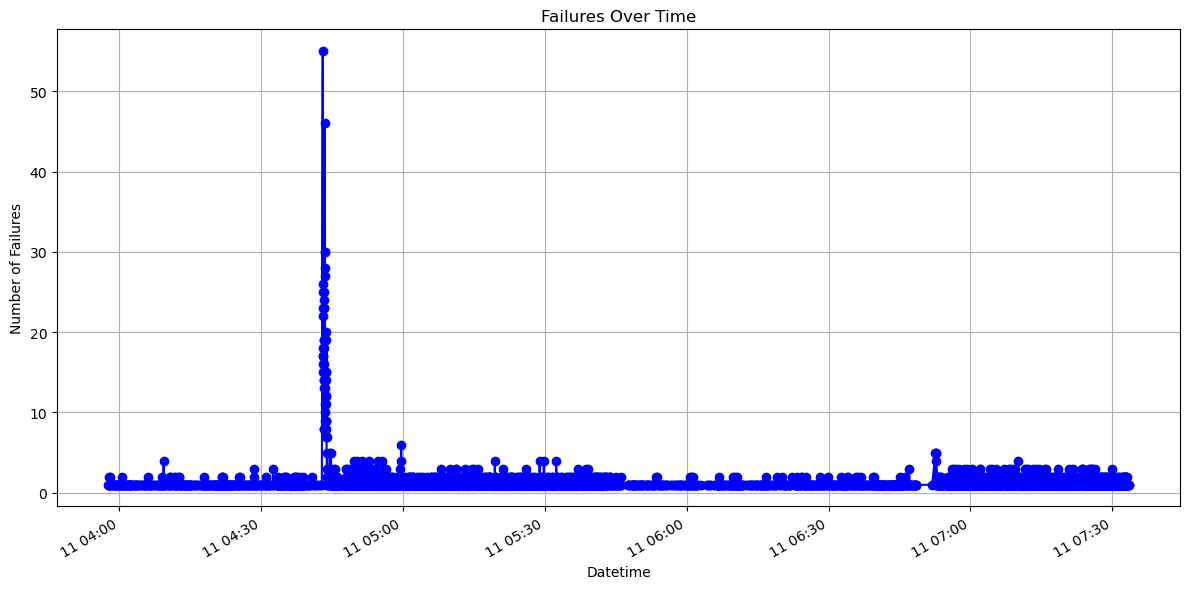

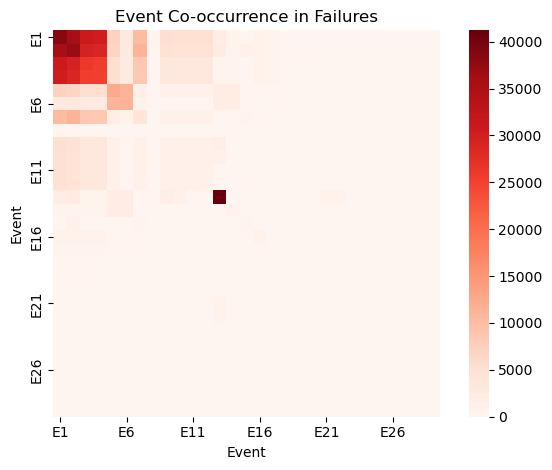


Failures by Type:
Type
13     1276
4       565
20      517
21      507
7       477
2       463
6       269
19      154
14      130
8       118
16       77
22       47
28       46
26       19
24       12
15        9
9         7
17        6
32        5
10        4
36        4
35        4
27        3
33        2
1         2
11        2
23        2
34        2
29        2
278       1
25        1
42        1
31        1
43        1
39        1
18        1
30        1
38        1
37        1
Name: count, dtype: int64


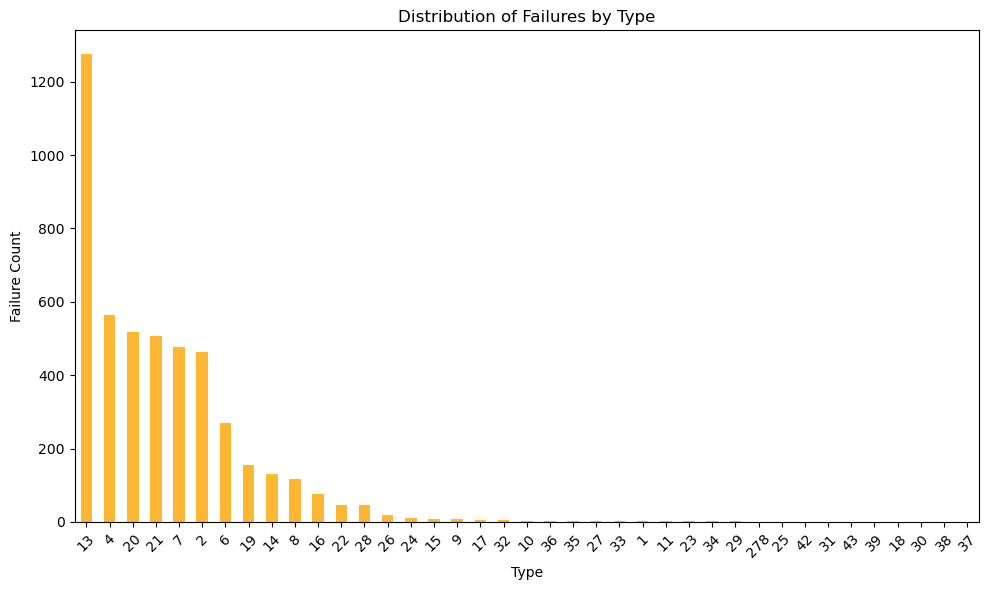

In [7]:
# Valid
matrix_path  = "HDFS_results/Event_occurence_matrix_HDFS_valid.csv"
generate_HDFS_statistiques(matrix_path)

Total Blocks: 180558
Total Failures: 4519
Failure Percentage: 2.50%

Top Events Contributing to Failures:
E5     10369
E6     10232
E2      4902
E1      3709
E3      2771
E4      2760
E9      2020
E7      1984
E15      591
E10      514
dtype: int64


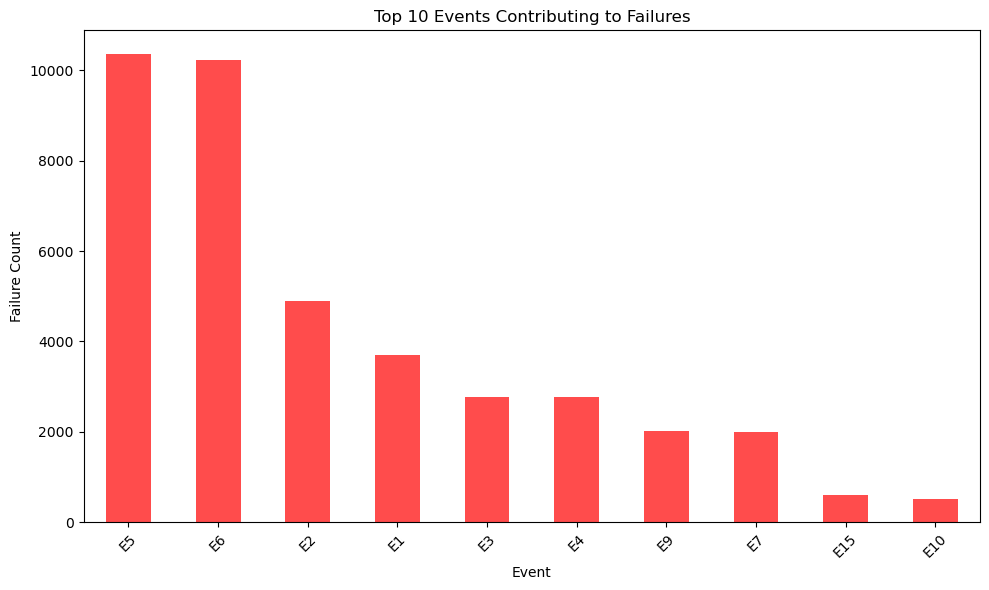


Failures Over Time:
Datetime
2008-11-11 07:33:31    1
2008-11-11 07:33:35    1
2008-11-11 07:33:37    1
2008-11-11 07:33:38    3
2008-11-11 07:33:39    2
                      ..
2008-11-11 11:01:03    1
2008-11-11 11:01:53    1
2008-11-11 11:02:01    1
2008-11-11 11:02:32    1
2008-11-11 11:04:13    1
Length: 1831, dtype: int64


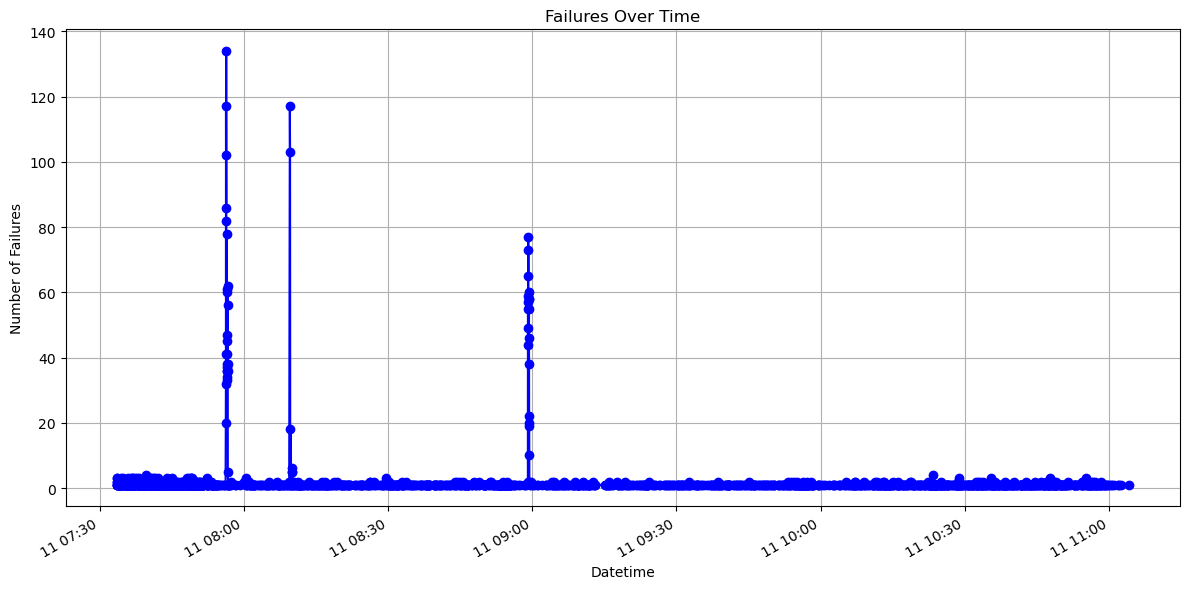

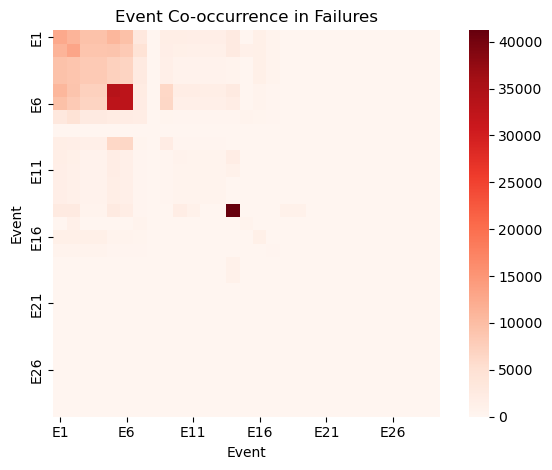


Failures by Type:
Type
7      1042
6       733
4       591
2       488
8       464
20      412
14      204
16      161
27       73
22       71
15       53
28       52
29       40
26       32
17       26
21       24
9        11
24        9
30        7
12        6
23        5
1         4
19        4
31        1
284       1
25        1
32        1
13        1
18        1
11        1
Name: count, dtype: int64


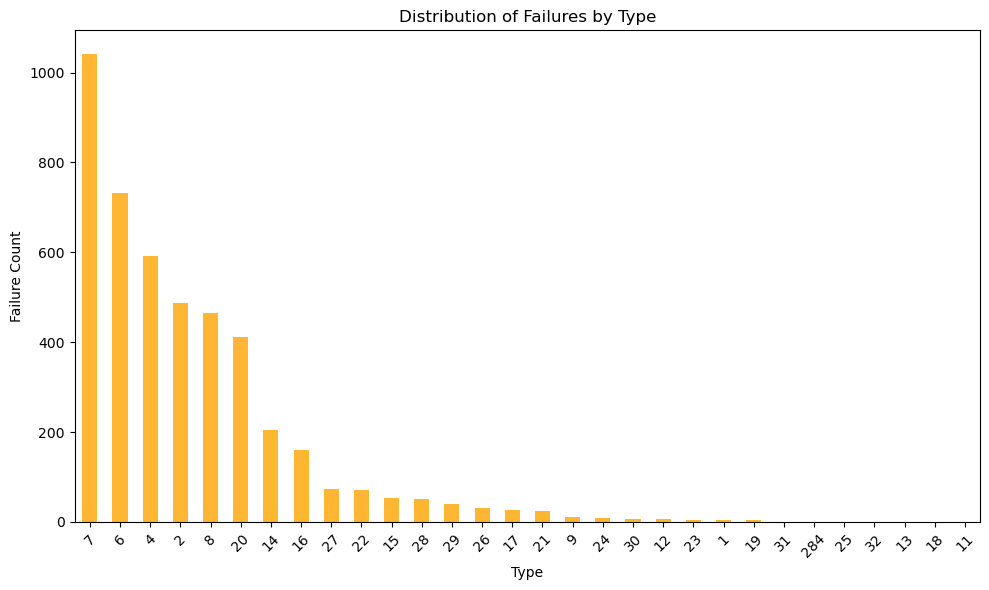

In [8]:
# Test
matrix_path  = "HDFS_results/Event_occurence_matrix_HDFS_test.csv"
generate_HDFS_statistiques(matrix_path)

## Construction du modèle et évaluation de ses performances

### Analyse des variables et traitement des corrélations